# Setup

In [1]:
!pip install biosignalsnotebooks

# Imports

In [2]:
import biosignalsnotebooks as bsnb
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [3]:
# from .conversion import raw_to_phy
# from .visualise import plot, opensignals_kwargs, opensignals_style, opensignals_color_pallet
# from .aux_functions import _butter_bandpass_filter, _moving_average

import numpy
from scipy.stats import linregress
from scipy.signal import filtfilt, butter

# Base packages used in OpenSignals Tools Notebooks for plotting data
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.layouts import gridplot

def detect_emg_activations(emg_signal, sample_rate, smooth_level=20, threshold_level=10,
                           time_units=False, volts=False, resolution=None, device="biosignalsplux",
                           plot_result=False):
    """
    -----
    Brief
    -----
    Python implementation of Burst detection algorithm using Teager Kaiser Energy Operator.

    -----------
    Description
    -----------
    Activation events in EMG readings correspond to an increase of muscular activity, namely, from inaction to action.
    These events are characterised by an increase in electric potential that returns to the initial values when the
    muscle returns to a state of inaction.

    This function detects activation events using the Teager Kaiser Energy Operator.

    ----------
    Parameters
    ----------
    emg_signal : list
        List of EMG acquired samples.

    sample_rate : int
        Sampling frequency.

    smooth_level : number
        Defines a percentage proportional to the smoothing level, i.e. the bigger this value is,
        the more smoothed is the signal.

    threshold_level : number
        Specification of the single threshold position, used for distinguishing between activation
        (above) and inactivation samples (below).

    time_units : boolean
        If True this function will return the Burst begin and end positions in seconds.

    volts : boolean
        If True, then the conversion of raw units to mV will be done. Resolution need to be
        specified.

    resolution : int
        Selected resolution for data acquisition.

    device : str
        Specification of the device category.

    plot_result : boolean
        If True it will be presented a graphical representation of the detected burst in the EMG
        signal.

    Returns
    -------
    out : bursts begin (ndarray), bursts end (ndarray)
        Begin and end of bursts (sample number or time instant in seconds).

    smooth_signal: list
        It is returned the smoothed EMG signal (after the processing steps intended to simplify the
        signal).

    threshold_level: float
        The value of the detection threshold used to locate the begin and end of each muscular
        activation period.
    """

    if volts is True:
        if resolution is not None:
            emg_signal = bsnb.raw_to_phy("EMG", device, emg_signal, resolution, option="mV")
            units = "mV"
        else:
            raise RuntimeError(
                "For converting raw units to mV is mandatory the specification of acquisition "
                "resolution.")
    else:
        units = "Input Units"

    if time_units is True:
        time_units_str = "Time (s)"
        time = np.linspace(0, len(emg_signal) / sample_rate, len(emg_signal))
    else:
        time = np.linspace(0, len(emg_signal) - 1, len(emg_signal))
        time_units_str = "Sample Number"

    # ----------------------------------- Baseline Removal -----------------------------------------
    pre_pro_signal = np.array(emg_signal) - np.average(emg_signal)

    # ------------------------------------ Signal Filtering ----------------------------------------
    low_cutoff = 10  # Hz
    high_cutoff = 40  # Hz

    # Application of the signal to the filter.
    pre_pro_signal = bsnb.aux_functions._butter_bandpass_filter(pre_pro_signal, low_cutoff, high_cutoff, sample_rate)

    # ------------------------------ Application of TKEO Operator ----------------------------------
    tkeo = []
    for i, signal_sample in enumerate(pre_pro_signal):
        if i in (0, len(pre_pro_signal) - 1):
            tkeo.append(signal_sample)
        else:
            tkeo.append(np.power(signal_sample, 2) - (pre_pro_signal[i + 1] *
                                                         pre_pro_signal[i - 1]))

    # Smoothing level - Size of sliding window used during the moving average process (a function
    # of sampling frequency)
    smoothing_level = int((smooth_level / 100) * sample_rate)

    # --------------------------------- Signal Rectification ---------------------------------------
    rect_signal = np.absolute(tkeo)

    # ------------------------------ First Moving Average Filter -----------------------------------
    rect_signal = bsnb.aux_functions._moving_average(rect_signal, sample_rate / 10)

    # -------------------------------- Second Smoothing Phase --------------------------------------
    smooth_signal = []
    for i in range(0, len(rect_signal)):
        if smoothing_level < i < len(rect_signal) - smoothing_level:
            smooth_signal.append(np.mean(rect_signal[i - smoothing_level:i + smoothing_level]))
        else:
            smooth_signal.append(0)

    # ----------------------------------- Threshold -----------------------------------------------
    avg_pre_pro_signal = np.average(pre_pro_signal)
    std_pre_pro_signal = np.std(pre_pro_signal)

    threshold_level = avg_pre_pro_signal + _thres_norm_reg(threshold_level, smooth_signal,
                                                           pre_pro_signal) * std_pre_pro_signal

    # Generation of a square wave reflecting the activation and inactivation periods.
    binary_signal = []
    for i in range(0, len(time)):
        if smooth_signal[i] >= threshold_level:
            binary_signal.append(1)
        else:
            binary_signal.append(0)

    # ------------------------------ Begin and End of Bursts --------------------------------------
    diff_signal = np.diff(binary_signal)
    act_begin = np.where(diff_signal == 1)[0]
    act_end = np.where(diff_signal == -1)[0]

    if time_units is True:
        time_begin = np.array(time)[act_begin]
        time_end = np.array(time)[act_end]
    else:
        time_begin = act_begin
        time_end = act_end

    # If plot is invoked by plot_result flag, then a graphical representation of the R peaks is
    # presented to the user.
    # if plot_result is True:
    #     plt.plot([list(time), list(time)], [list(emg_signal), list(np.array(binary_signal) *
    #                                                            np.max(emg_signal))],
    #          yAxisLabel=["Data Samples (" + units + ")"] * 2,
    #          x_axis_label=time_units_str, legend_label=["EMG Signal", "Activation Signal"])

    return time_begin, time_end, smooth_signal, threshold_level

def _thres_norm_reg(threshold_level, signal, pre_smooth_signal):
    """
    Regression function that with a percent input gives an absolute value of the threshold
    level (used in the muscular activation detection algorithm).
    Converts a relative threshold level to an absolute value.

    ----------
    Parameters
    ----------
    threshold_level : int
        Percentage value that defines the absolute threshold level relatively to the maximum value
        of signal.
    signal : list
        List of EMG smoothed signal samples.
    pre_smooth_signal : list
        Original EMG samples.

    Returns
    -------
    out : float
        Threshold level in absolute format.

     """
    avg_signal = numpy.average(pre_smooth_signal)
    std_signal = numpy.std(pre_smooth_signal)

    threshold_0_perc_level = (-avg_signal) / float(std_signal)
    threshold_100_perc_level = (numpy.max(signal) - avg_signal) / float(std_signal)

    slope, b_coeff = linregress([0, 100], [threshold_0_perc_level, threshold_100_perc_level])[:2]
    return slope * threshold_level + b_coeff

In [4]:
import numpy
import scipy
import scipy.signal as scisignal
import scipy.interpolate as interpol
import scipy.integrate as integr
import pandas
from bokeh.models import BoxAnnotation
from bokeh.plotting import show
from bokeh.layouts import gridplot
# from .detect import tachogram, detect_emg_activations
# from .conversion import raw_to_phy
# from .visualise import plot, opensignals_kwargs, opensignals_color_pallet

def fatigue_eval_med_freq(data, sample_rate, time_units=True, raw_to_mv=True,
                          device="biosignalsplux", resolution=16, show_plot=False):
    """
    -----
    Brief
    -----
    Returns the evolution time series of EMG median frequency along the acquisition, based on a sliding window
    mechanism.

    -----------
    Description
    -----------
    The median frequency of activation events in EMG signal is particularly important in fatigue evaluation methods.

    This function calculates the median frequency of each activation period and allows to plot those values in order to
    see the temporal evolution of this particular feature.

    ----------
    Parameters
    ----------
    data : list
        EMG signal.

    sample_rate : int
        Sampling frequency.

    time_units : boolean
        If True this function will return the x axis samples in seconds.

    raw_to_mv : boolean
        If True then it is assumed that the input samples are in a raw format and the output
        results will be in mV. When True "device" and "resolution" inputs became mandatory.

    device : str
        PLUX device label:
        - "bioplux"
        - "bioplux_exp"
        - "biosignalsplux"
        - "rachimeter"
        - "channeller"
        - "swifter"
        - "ddme_openbanplux"

    resolution : int
        Resolution selected during acquisition.

    show_plot : boolean
        If True, then a figure with the median frequency evolution will be shown.

    Returns
    -------
    out : pandas.DataFrame
        DataFrame with the time and the sequence of median frequency evolution.
    """

    # Conversion of data samples to mV if requested by raw_to_mv input.
    if raw_to_mv is True:
        data = bsnb.conversion.raw_to_phy("EMG", device, data, resolution, option="mV")

    # Definition of the time axis.
    if time_units is True:
        time = numpy.linspace(0, len(data) / sample_rate, len(data))
    else:
        time = numpy.linspace(0, len(data) - 1, len(data))

    # Detection of muscular activation periods.
    burst_begin, burst_end = detect_emg_activations(data, sample_rate, smooth_level=20,
                                                    threshold_level=10, time_units=False,
                                                    volts=True, resolution=resolution,
                                                    device=device, plot_result=False)[:2]

    # Iteration along bursts.
    median_freq_data = []
    median_freq_time = []
    for burst in range(0, len(burst_begin)):
        processing_window = data[burst_begin[burst]:burst_end[burst]]
        central_point = (burst_begin[burst] + burst_end[burst]) / 2
        median_freq_time.append(central_point / sample_rate)

        # Generation of the processing window power spectrum.
        freqs, power = scisignal.welch(processing_window, fs=sample_rate,
                                       window='hanning' if scipy.__version__ <= "1.8.1" else "hann",
                                       noverlap=0, nfft=int(256.))

        # Determination of median power frequency.
        area_freq = integr.cumtrapz(power, freqs, initial=0)
        total_power = area_freq[-1]
        median_freq_data.append(freqs[numpy.where(area_freq >= total_power / 2)[0][0]])

    # Graphical Representation step.
    # if show_plot is True:
    #     list_figures_1 = plt.plot([list(time), list(median_freq_time)],
    #                           [list(data), list(median_freq_data)],
    #                           title=["EMG Acquisition highlighting bursts",
    #                                  "Median Frequency Evolution"], gridPlot=True,
    #                           gridLines=2, gridColumns=1, openSignalsStyle=True,
    #                           x_axis_label="Time (s)",
    #                           yAxisLabel=["Raw Data", "Median Frequency (Hz)"],
    #                           x_range=[0, 125], show_plot=False)

    #     # Highlighting processing window.
    #     for burst in range(0, len(burst_begin)):
    #         color = opensignals_color_pallet()
    #         box_annotation = BoxAnnotation(left=burst_begin[burst] / sample_rate,
    #                                        right=burst_end[burst] / sample_rate, fill_color=color,
    #                                        fill_alpha=0.1)
    #         box_annotation_copy = BoxAnnotation(left=burst_begin[burst] / sample_rate,
    #                                             right=burst_end[burst] / sample_rate,
    #                                             fill_color=color, fill_alpha=0.1)
    #         list_figures_1[0].add_layout(box_annotation)
    #         list_figures_1[1].add_layout(box_annotation_copy)

    #     gridplot_1 = gridplot([[list_figures_1[0]], [list_figures_1[1]]],
    #                           **opensignals_kwargs("gridplot"))
    #     show(gridplot_1)

    # pandas.DataFrame(a, columns=a.keys())
    # pandas.DataFrame([a], columns=a.keys())
    return median_freq_time, median_freq_data

# Raw Data

In [5]:
signals = np.genfromtxt('project_trial_daniel.txt') # Raw signals
shot_times = np.genfromtxt("daniel_shot_times.txt", delimiter=',')[:, 0] # Times of shots
shots = np.genfromtxt("daniel_makes.txt", delimiter=',')[:, 0] # Shot outcomes
jumps = np.genfromtxt("daniel_jumps.txt", delimiter=',')[:, 0] # Jump times

In [6]:
vcc = 3000 # Operating voltage
gain = 1000 # Sensor gain
resolution = 10 # Resolution
fs = 100 # Sampling rate

remg_raw = signals[:, -6] # Raw EMG signals
lemg_raw = signals[:, -5] # Raw EMG signals

rtime_begin, rtime_end, remg_processed, threshold_level = detect_emg_activations(remg_raw, fs, smooth_level=20, threshold_level=10,
                                                                time_units=True, volts=True, resolution=resolution, plot_result=False)
remg_processed = np.array(remg_processed)
ltime_begin, ltime_end, lemg_processed, threshold_level = detect_emg_activations(lemg_raw, fs, smooth_level=20, threshold_level=10,
                                                                time_units=True, volts=True, resolution=resolution, plot_result=False)
lemg_processed = np.array(lemg_processed)

time = bsnb.generate_time(remg_processed, fs) # Generate time axis

In [7]:
lprobable_peaks, lpossible_peaks = bsnb.detect._detects_peaks(lemg_processed, fs)
lprobable_peaks = np.array(lprobable_peaks)
rprobable_peaks, rpossible_peaks = bsnb.detect._detects_peaks(remg_processed, fs)
rprobable_peaks = np.array(rprobable_peaks)
time = np.array(time)
left_peaks_times = np.round(time[lprobable_peaks],0)
right_peaks_times = np.round(time[rprobable_peaks],0)
matched_peaks = time[lprobable_peaks[np.isin(left_peaks_times, right_peaks_times)]]
new_shot_times = []
for shot_time in shot_times:
  if np.min(np.abs(matched_peaks-shot_time)) > 2:
    new_shot_times.append(shot_time)
  else:
    new_shot_times.append(matched_peaks[np.argmin(np.abs(matched_peaks-shot_time))])
new_jumps = []
for jump in jumps:
  if np.min(np.abs(matched_peaks-jump)) > 2:
    new_jumps.append(jump)
  else:
    new_jumps.append(matched_peaks[np.argmin(np.abs(matched_peaks-jump))])

shot_times = np.array(new_shot_times)
make_times = shot_times[shots==1] # Times of makes
miss_times = shot_times[shots==0] # Times of misses
jumps = np.array(new_jumps)

# FG %

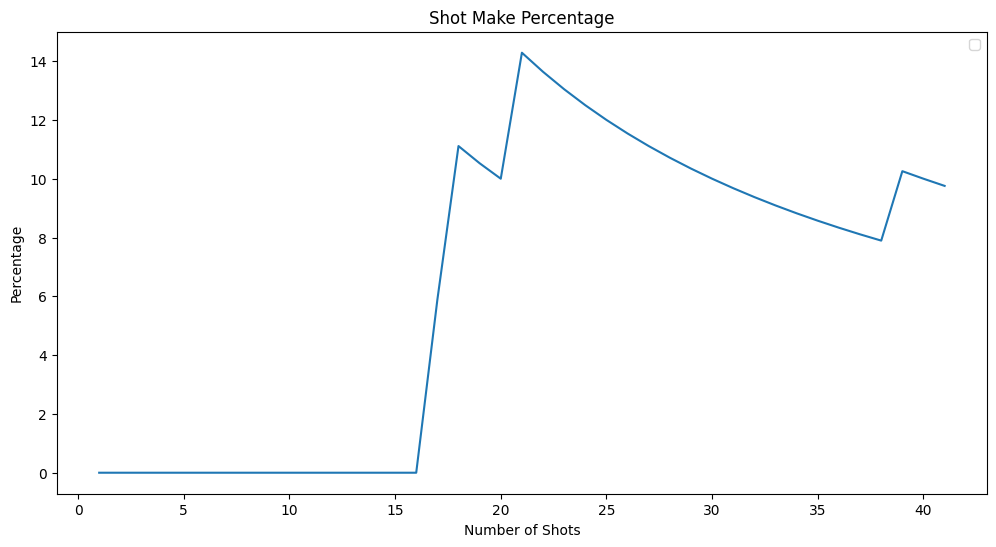

In [8]:
shot_count = np.arange(1, len(shots) + 1)
fgp = np.cumsum(shots) / shot_count

plt.figure(figsize=(12, 6))
plt.plot(shot_count, fgp * 100)
plt.xlabel('Number of Shots')
plt.ylabel('Percentage')
plt.title('Shot Make Percentage')
plt.legend()
plt.show()

In [9]:
print(fgp[-1])

0.0975609756097561


# Accelerometer

In [10]:
accelerometer_raw = signals[:, -2] # Raw accelerometer signals
resolution = 6 # Resolution

In [11]:
accelerometer_filtered = bsnb.lowpass(accelerometer_raw, 50, order=2, use_filtfilt=True) # Filtered accelerometer signals
c_min = np.min(accelerometer_filtered) # Calibration min
c_max = np.max(accelerometer_filtered) # Calibration max
accelerometer_converted = ((np.array(accelerometer_filtered) - c_min) / (c_max - c_min)) * 2 - 1 # Unit conversion

In [12]:
time = bsnb.generate_time(accelerometer_converted, fs) # Generate time axis

plt.figure(figsize=(12, 6))
plt.plot(time, accelerometer_converted, label='Accelerometer Signal')
plt.vlines(make_times, -1, 1, colors='g', linestyles='dotted', label = "Made Shots")
plt.vlines(miss_times, -1, 1, colors='r', linestyles='dotted', label = "Missed Shots")
plt.vlines(jumps, -1, 1, colors='b', linestyles='dotted', label = "Jumps")
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration (g)')
# plt.xlim(208,212)
plt.title('Accelerometer Signal')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [12]:
shot_start_indices = shot_times * 100
shot_end_indices = shot_start_indices + 150
one_second_shot_data = []
for i in range(len(shot_start_indices)):
  one_second_shot_data.append(accelerometer_converted[int(shot_start_indices[i]):int(shot_end_indices[i])])
one_second_shot_data = np.array(one_second_shot_data)

one_second_shot_maxes = np.max(one_second_shot_data, axis = 1)
one_second_make_maxes = one_second_shot_maxes[shots==1]
one_second_miss_maxes = one_second_shot_maxes[shots==0]

one_second_shot_mins = np.min(one_second_shot_data, axis = 1)
one_second_make_mins = one_second_shot_mins[shots==1]
one_second_miss_mins = one_second_shot_mins[shots==0]

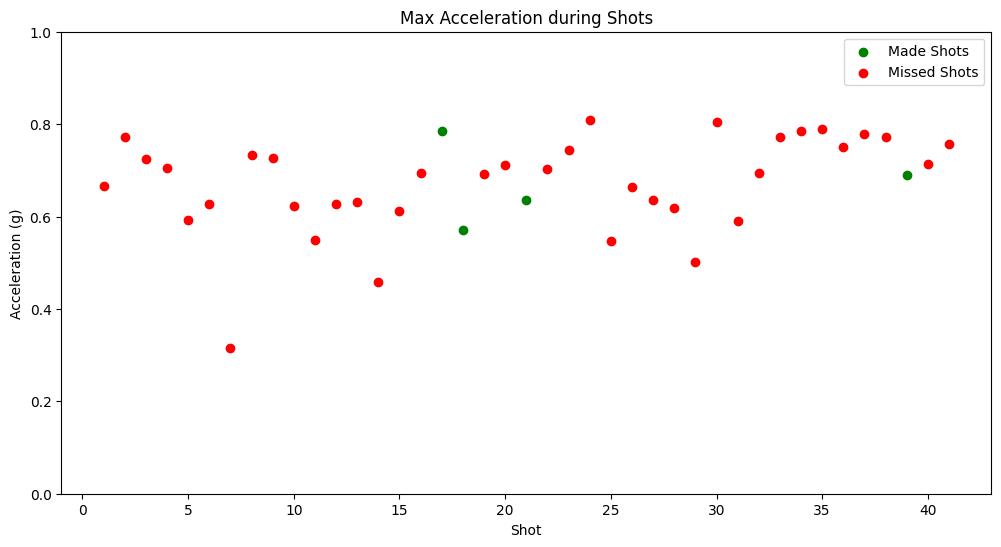

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(np.argwhere(shots==1) + 1, one_second_make_maxes, c='g', label='Made Shots')
plt.scatter(np.argwhere(shots==0) + 1, one_second_miss_maxes, c='r', label='Missed Shots')
plt.xlabel('Shot')
plt.ylabel('Acceleration (g)')
plt.ylim(0,1)
plt.title('Max Acceleration during Shots')
plt.legend()
plt.show()

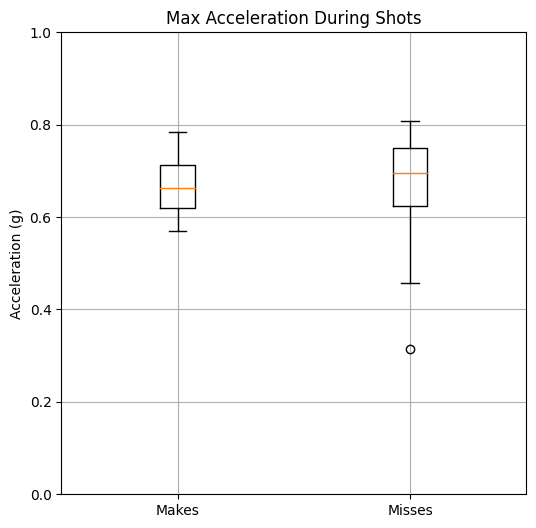

In [14]:
plt.figure(figsize=(6, 6))
plt.boxplot([one_second_make_maxes, one_second_miss_maxes], labels = ["Makes", "Misses"])
plt.ylabel('Acceleration (g)')
plt.ylim(0,1)
plt.title('Max Acceleration During Shots')
plt.grid(True)
plt.show()

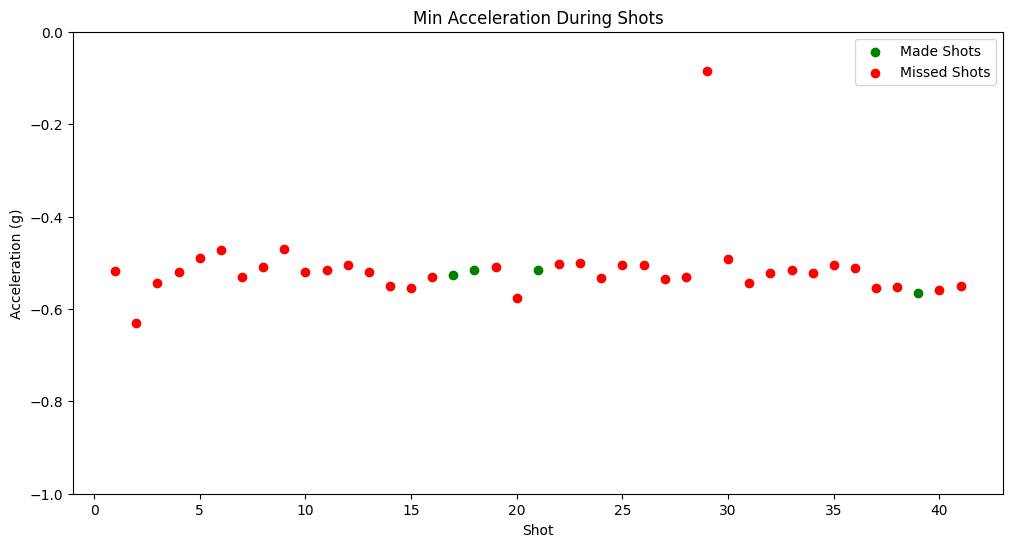

In [15]:
plt.figure(figsize=(12, 6))
plt.scatter(np.argwhere(shots==1) + 1, one_second_make_mins, c='g', label='Made Shots')
plt.scatter(np.argwhere(shots==0) + 1, one_second_miss_mins, c='r', label='Missed Shots')
plt.xlabel('Shot')
plt.ylabel('Acceleration (g)')
plt.ylim(-1,0)
plt.title('Min Acceleration During Shots')
plt.legend()
plt.show()

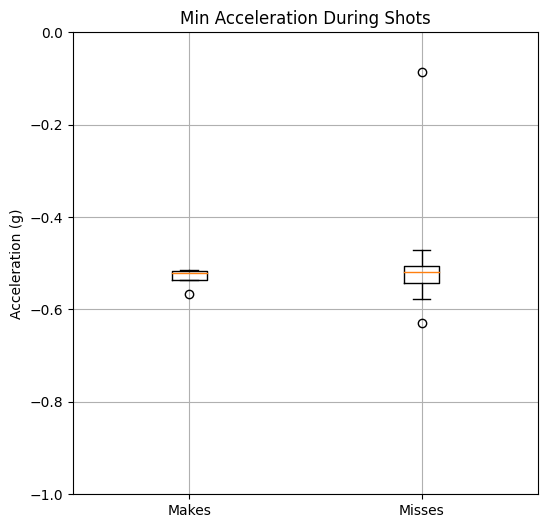

In [16]:
plt.figure(figsize=(6, 6))
plt.boxplot([one_second_make_mins, one_second_miss_mins], labels = ["Makes", "Misses"])
plt.ylabel('Acceleration (g)')
plt.ylim(-1,0)
plt.title('Min Acceleration During Shots')
plt.grid(True)
plt.show()

# Right EMG

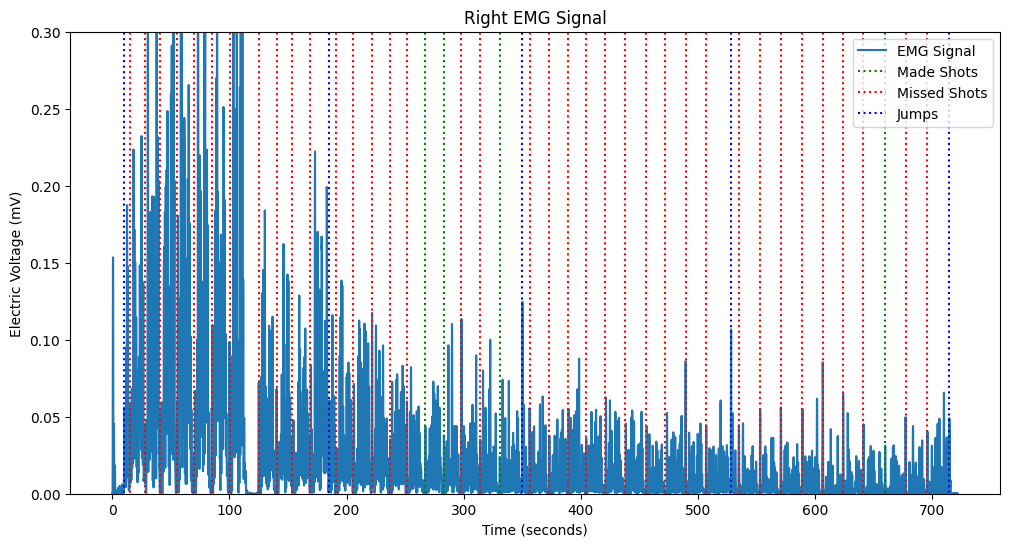

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(time, remg_processed, label='EMG Signal')
plt.vlines(make_times, -1, 1, colors='g', linestyles='dotted', label = "Made Shots")
plt.vlines(miss_times, -1, 1, colors='r', linestyles='dotted', label = "Missed Shots")
plt.vlines(jumps, -1, 1, colors='b', linestyles='dotted', label = "Jumps")
plt.xlabel('Time (seconds)')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.3)
# plt.xlim(0,50)
plt.title('Right EMG Signal')
plt.legend()
plt.show()

In [18]:
shot_start_indices = shot_times * 100
shot_end_indices = shot_start_indices + 150
rone_second_shot_data = []
for i in range(len(shot_start_indices)):
  rone_second_shot_data.append(remg_processed[int(shot_start_indices[i]):int(shot_end_indices[i])])
rone_second_shot_data = np.array(rone_second_shot_data)
rone_second_shot_max = np.max(rone_second_shot_data, axis = 1)
rone_second_make_max = rone_second_shot_max[shots==1]
rone_second_miss_max = rone_second_shot_max[shots==0]

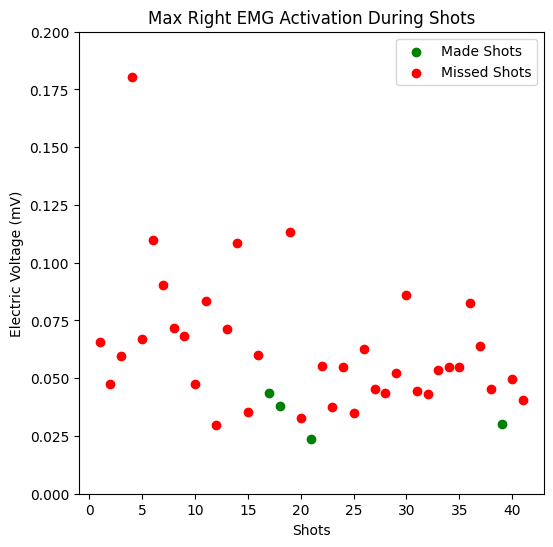

In [19]:
plt.figure(figsize=(6, 6))
plt.scatter(np.argwhere(shots==1) + 1, rone_second_make_max, c='g', label='Made Shots')
plt.scatter(np.argwhere(shots==0) + 1, rone_second_miss_max, c='r', label='Missed Shots')
plt.xlabel('Shots')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.2)
plt.title('Max Right EMG Activation During Shots')
plt.legend()
plt.show()

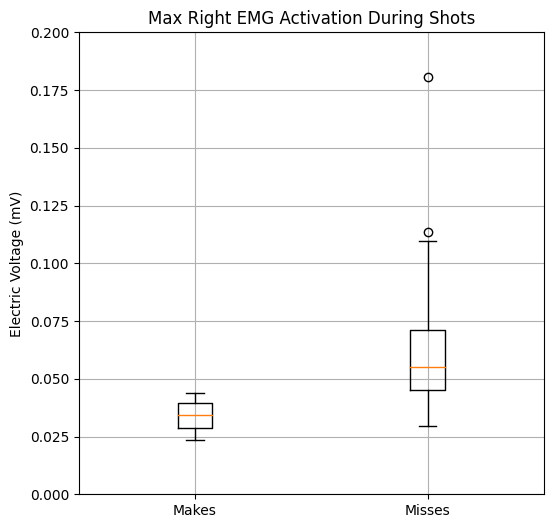

In [20]:
plt.figure(figsize=(6, 6))
plt.boxplot([rone_second_make_max, rone_second_miss_max], labels = ["Makes", "Misses"])
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.2)
plt.title('Max Right EMG Activation During Shots')
plt.grid(True)
plt.show()

In [21]:
jump_start_indices = jumps * 100
jump_end_indices = jump_start_indices + 150
rone_second_jump_data = []
for i in range(len(jump_start_indices)):
  rone_second_jump_data.append(remg_processed[int(jump_start_indices[i]):int(jump_end_indices[i])])
rone_second_jump_data = np.array(rone_second_jump_data)
rone_second_jump_max = np.max(rone_second_jump_data, axis = 1)

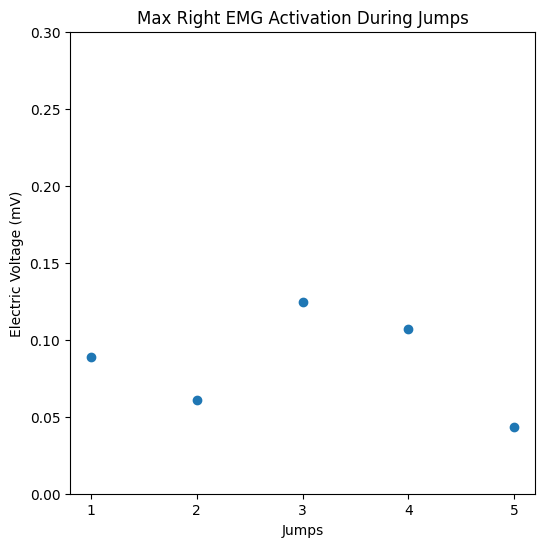

In [22]:
plt.figure(figsize=(6, 6))
plt.scatter(np.arange(len(jumps)) + 1, rone_second_jump_max)
plt.xlabel('Jumps')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.3)
plt.xticks(np.arange(1, 6))
plt.title('Max Right EMG Activation During Jumps')
plt.show()

# Left EMG

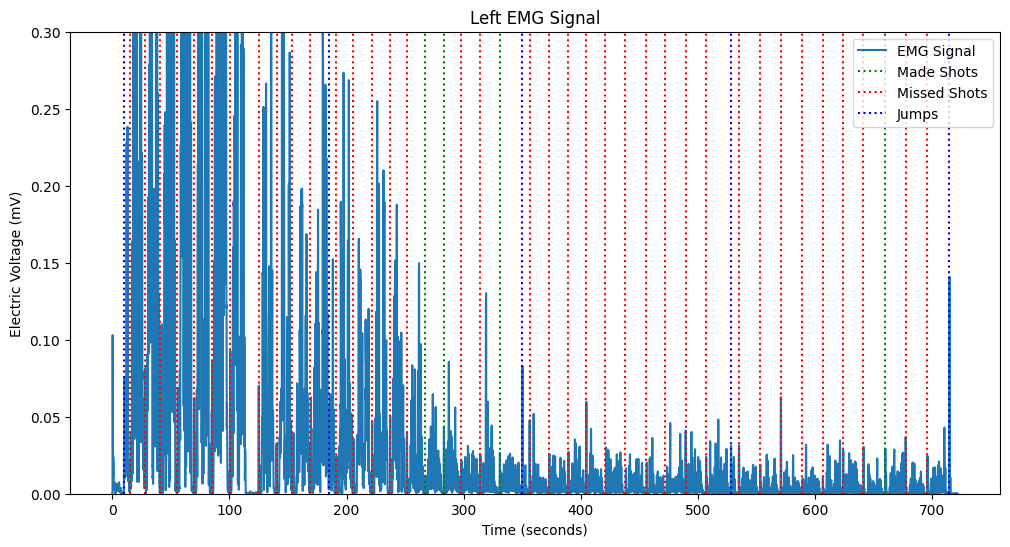

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(time, lemg_processed, label='EMG Signal')
plt.vlines(make_times, 0, 0.35, colors='g', linestyles='dotted', label = "Made Shots")
plt.vlines(miss_times, 0, 0.35, colors='r', linestyles='dotted', label = "Missed Shots")
plt.vlines(jumps, 0, 0.35, colors='b', linestyles='dotted', label = "Jumps")
plt.xlabel('Time (seconds)')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.3)
# plt.xlim(100,150)
plt.title('Left EMG Signal')
plt.legend()
plt.show()

In [24]:
shot_start_indices = shot_times * 100
shot_end_indices = shot_start_indices + 150
lone_second_shot_data = []
for i in range(len(shot_start_indices)):
  lone_second_shot_data.append(lemg_processed[int(shot_start_indices[i]):int(shot_end_indices[i])])
lone_second_shot_data = np.array(lone_second_shot_data)
lone_second_shot_max = np.max(lone_second_shot_data, axis = 1)
lone_second_make_max = lone_second_shot_max[shots==1]
lone_second_miss_max = lone_second_shot_max[shots==0]

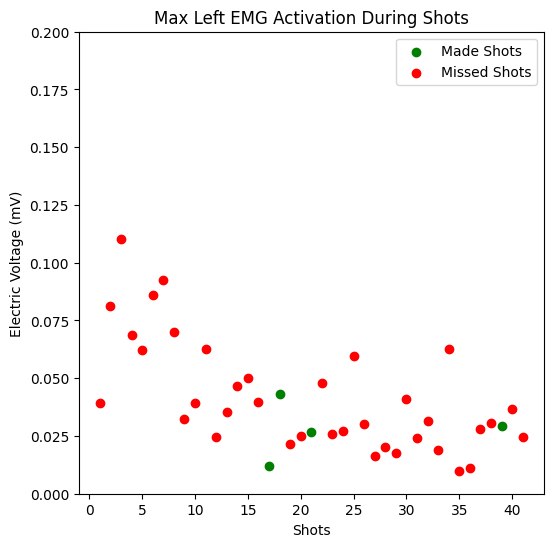

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(np.argwhere(shots==1) + 1, lone_second_make_max, c='g', label='Made Shots')
plt.scatter(np.argwhere(shots==0) + 1, lone_second_miss_max, c='r', label='Missed Shots')
plt.xlabel('Shots')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.2)
plt.title('Max Left EMG Activation During Shots')
plt.legend()
plt.show()

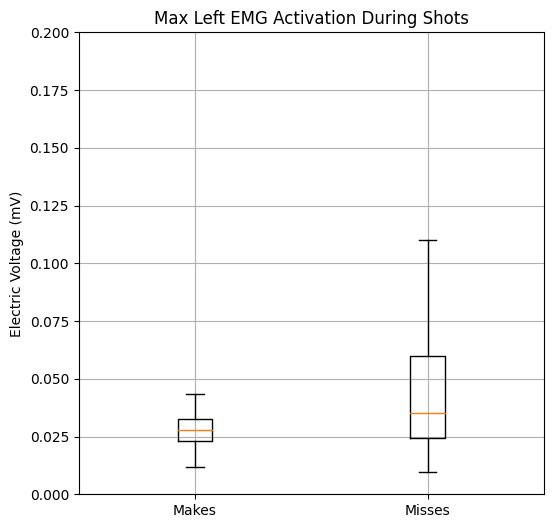

In [26]:
plt.figure(figsize=(6, 6))
plt.boxplot([lone_second_make_max, lone_second_miss_max], labels = ["Makes", "Misses"])
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.2)
plt.title('Max Left EMG Activation During Shots')
plt.grid(True)
plt.show()

In [27]:
jump_start_indices = jumps * 100
jump_end_indices = jump_start_indices + 150
lone_second_jump_data = []
for i in range(len(jump_start_indices)):
  lone_second_jump_data.append(lemg_processed[int(jump_start_indices[i]):int(jump_end_indices[i])])
lone_second_jump_data = np.array(lone_second_jump_data)
lone_second_jump_max = np.max(lone_second_jump_data, axis = 1)

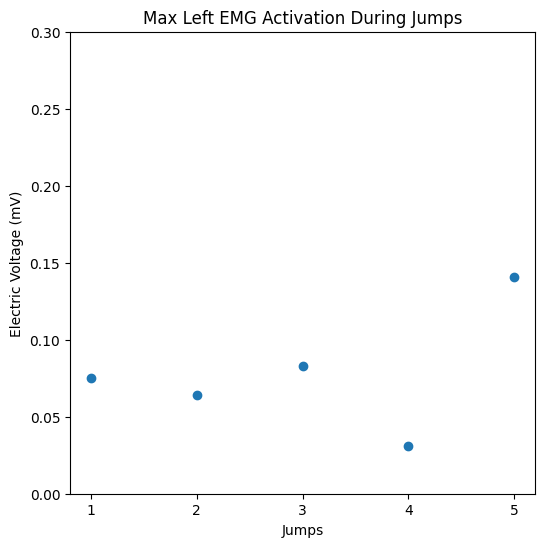

In [28]:
plt.figure(figsize=(6, 6))
plt.scatter(np.arange(len(jumps)) + 1, lone_second_jump_max)
plt.xlabel('Jumps')
plt.ylabel('Electric Voltage (mV)')
plt.xticks(np.arange(1, 6))
plt.ylim(0,0.3)
plt.title('Max Left EMG Activation During Jumps')
plt.show()

# Both EMG

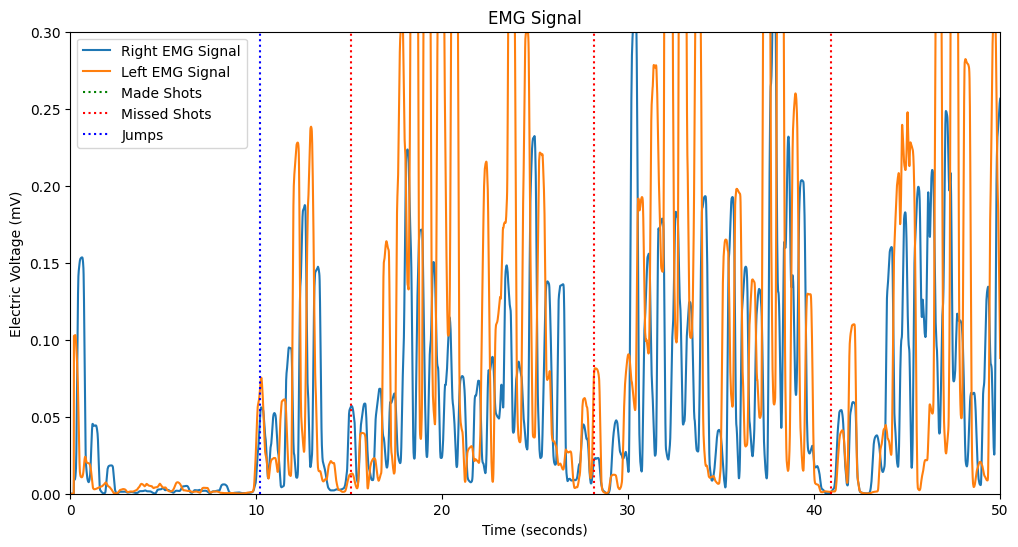

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(time, remg_processed, label='Right EMG Signal')
plt.plot(time, lemg_processed, label='Left EMG Signal')
plt.vlines(make_times, 0, 0.35, colors='g', linestyles='dotted', label = "Made Shots")
plt.vlines(miss_times, 0, 0.35, colors='r', linestyles='dotted', label = "Missed Shots")
plt.vlines(jumps, 0, 0.35, colors='b', linestyles='dotted', label = "Jumps")
plt.xlabel('Time (seconds)')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.3)
plt.xlim(0,50)
plt.title('EMG Signal')
plt.legend()
plt.show()

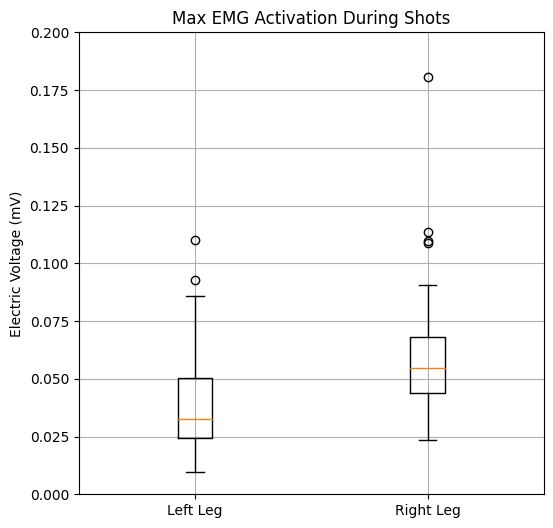

In [30]:
plt.figure(figsize=(6, 6))
plt.boxplot([lone_second_shot_max, rone_second_shot_max], labels = ["Left Leg", "Right Leg"])
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0, 0.2)
plt.title('Max EMG Activation During Shots')
plt.grid(True)
plt.show()

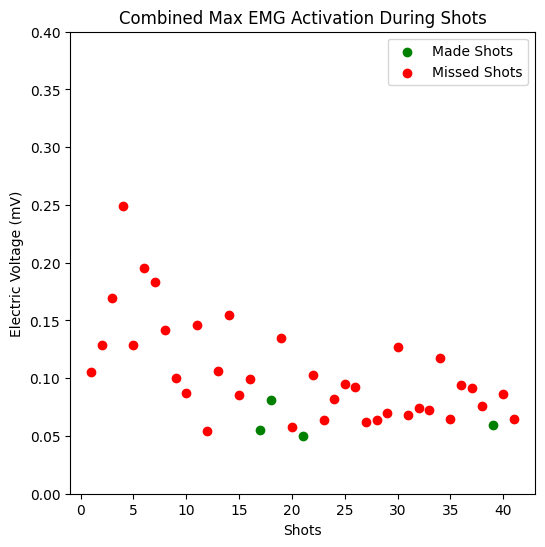

In [31]:
one_second_make_max = (rone_second_make_max + lone_second_make_max)
one_second_miss_max = (rone_second_miss_max + lone_second_miss_max)

plt.figure(figsize=(6, 6))
plt.scatter(np.argwhere(shots==1) + 1, one_second_make_max, c='g', label='Made Shots')
plt.scatter(np.argwhere(shots==0) + 1, one_second_miss_max, c='r', label='Missed Shots')
plt.xlabel('Shots')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0,0.4)
plt.title('Combined Max EMG Activation During Shots')
plt.legend()
plt.show()

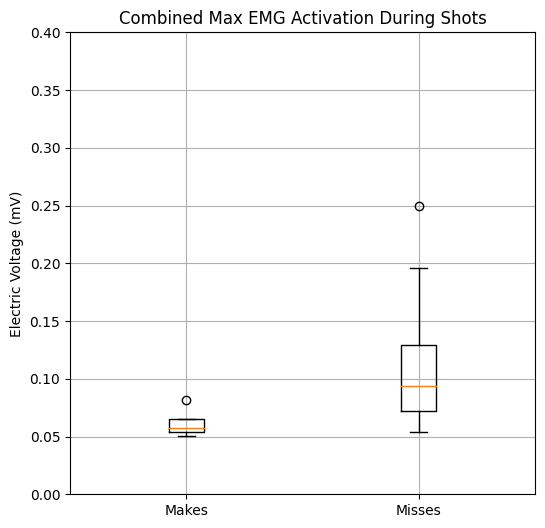

In [32]:
plt.figure(figsize=(6, 6))
plt.boxplot([one_second_make_max, one_second_miss_max], labels = ["Makes", "Misses"])
plt.ylabel('Electric Voltage (mV)')
plt.ylim(0, 0.4)
plt.title('Combined Max EMG Activation During Shots')
plt.grid(True)
plt.show()

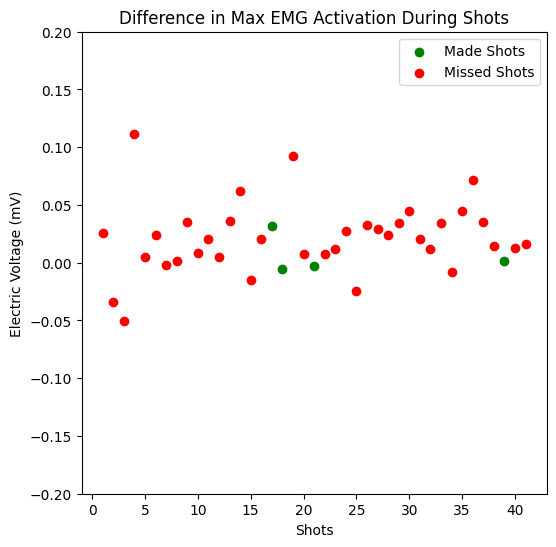

In [33]:
one_second_make_diff = (rone_second_make_max - lone_second_make_max)
one_second_miss_diff = (rone_second_miss_max - lone_second_miss_max)

plt.figure(figsize=(6, 6))
plt.scatter(np.argwhere(shots==1) + 1, one_second_make_diff, c='g', label='Made Shots')
plt.scatter(np.argwhere(shots==0) + 1, one_second_miss_diff, c='r', label='Missed Shots')
plt.xlabel('Shots')
plt.ylabel('Electric Voltage (mV)')
plt.ylim(-0.2,0.2)
plt.title('Difference in Max EMG Activation During Shots')
plt.legend()
plt.show()

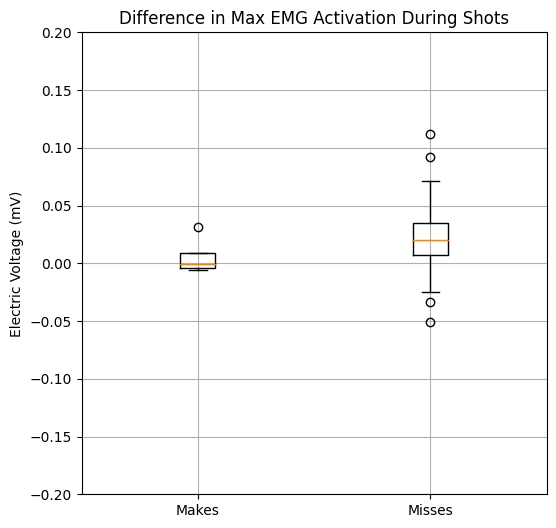

In [34]:
plt.figure(figsize=(6, 6))
plt.boxplot([one_second_make_diff, one_second_miss_diff], labels = ["Makes", "Misses"])
plt.ylabel('Electric Voltage (mV)')
plt.ylim(-0.2,0.2)
plt.title('Difference in Max EMG Activation During Shots')
plt.grid(True)
plt.show()

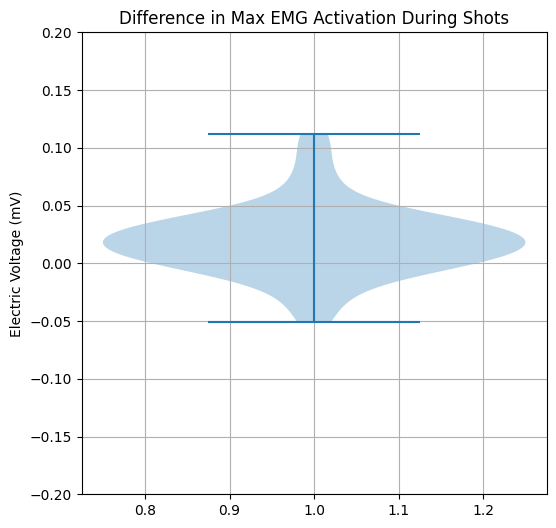

In [35]:
plt.figure(figsize=(6, 6))
plt.violinplot(np.concatenate([one_second_make_diff, one_second_miss_diff]))
plt.ylabel('Electric Voltage (mV)')
plt.ylim(-0.2,0.2)
plt.title('Difference in Max EMG Activation During Shots')
plt.grid(True)
plt.show()

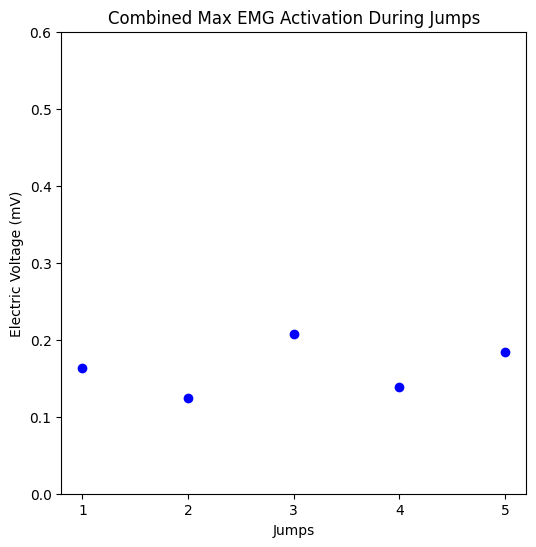

In [36]:
one_second_jump_max = rone_second_jump_max + lone_second_jump_max

plt.figure(figsize=(6, 6))
plt.scatter(np.arange(len(jumps)) + 1, one_second_jump_max, c='b')
plt.xlabel('Jumps')
plt.ylabel('Electric Voltage (mV)')
plt.xticks(np.arange(1, 6))
plt.ylim(0,0.6)
plt.title('Combined Max EMG Activation During Jumps')
plt.show()

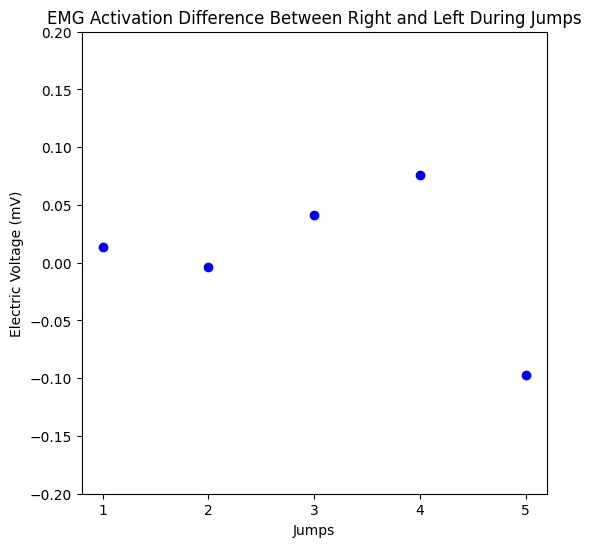

In [37]:
one_second_jump_diff = rone_second_jump_max - lone_second_jump_max

plt.figure(figsize=(6, 6))
plt.scatter(np.arange(len(jumps)) + 1, one_second_jump_diff, c='b')
plt.xlabel('Jumps')
plt.ylabel('Electric Voltage (mV)')
plt.xticks(np.arange(1, 6))
plt.ylim(-0.2,0.2)
plt.title('EMG Activation Difference Between Right and Left During Jumps')
plt.show()

# PZT Respiration

In [38]:
resolution = 10 # Resolution

In [39]:
pzt_raw = signals[:, -4] # Raw PZT respiration signals
pzt_filtered = bsnb.lowpass(pzt_raw, f=1, order=2, fs=fs, use_filtfilt=True) # Filtered PZT respiration signals

window_size = 90
pzt_window = np.convolve(pzt_filtered, np.ones(window_size), 'valid') / window_size

pzt_converted = ((np.array(pzt_window) / 2**resolution) - 0.5)*100 # Unit conversion

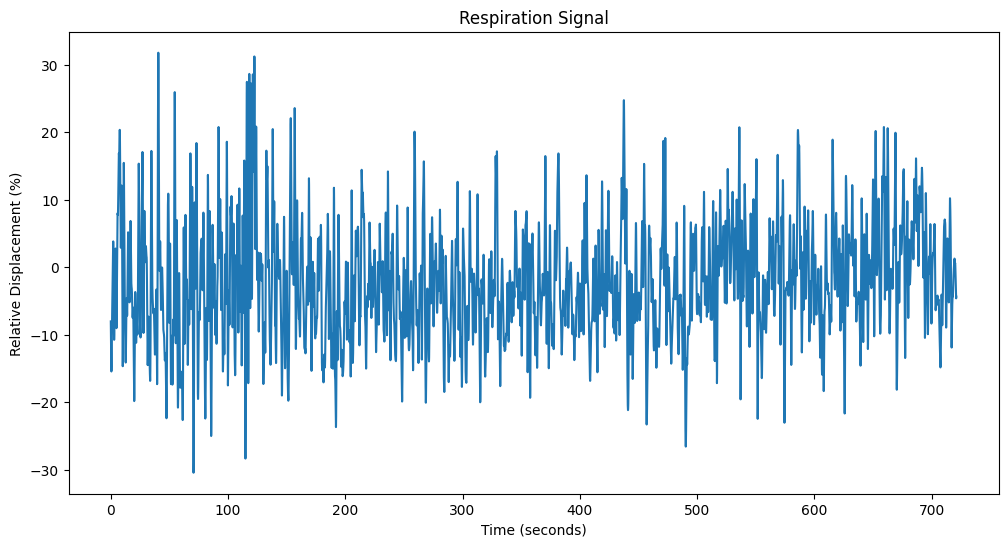

In [40]:
time = np.array(bsnb.generate_time(pzt_converted, fs)) # Generate time axis

plt.figure(figsize=(12, 6))
plt.plot(time, pzt_converted)
plt.xlabel('Time (seconds)')
# plt.xlim(300,330)
plt.ylabel('Relative Displacement (%)')
plt.title('Respiration Signal')
plt.show()

In [41]:
probable_peaks, possible_peaks = bsnb.detect._detects_peaks(pzt_converted, fs)

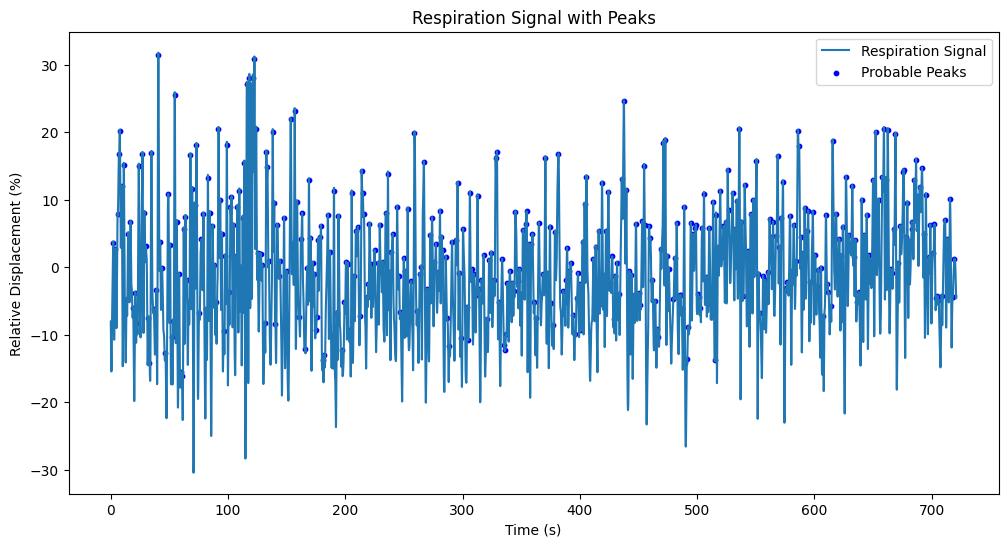

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(time, pzt_converted, label='Respiration Signal')
plt.scatter(time[probable_peaks], pzt_converted[probable_peaks], s=10, color='blue', label='Probable Peaks')
plt.xlabel('Time (s)')
# plt.xlim(300,330)
plt.ylabel('Relative Displacement (%)')
plt.title('Respiration Signal with Peaks')
plt.legend()
plt.show()

In [43]:
tachogram = np.diff(time[probable_peaks])

tachogram_time = (time[probable_peaks][1:] + time[probable_peaks][:-1]) / 2

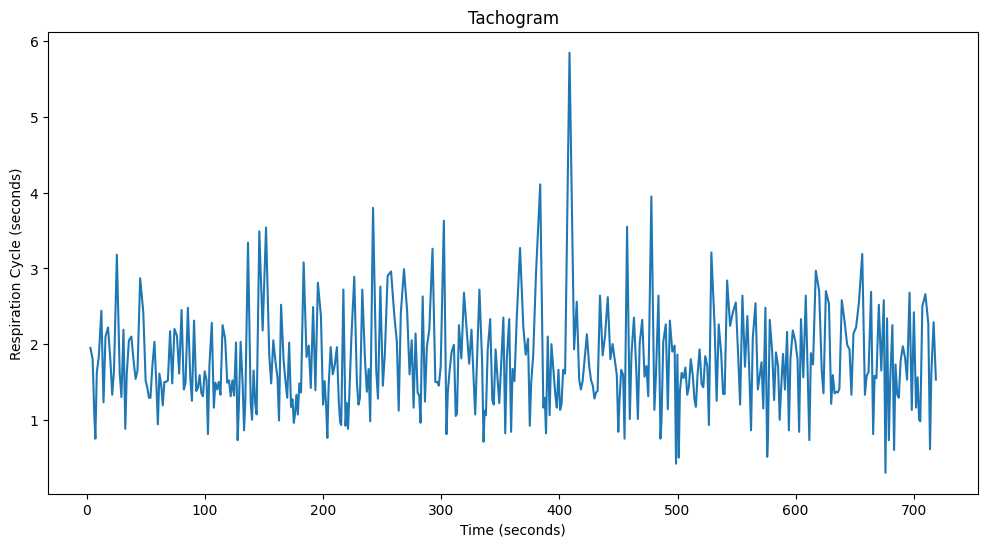

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(tachogram_time, tachogram)
plt.xlabel('Time (seconds)')
# plt.xlim(300,330)
# plt.ylim(25,50)
plt.ylabel('Respiration Cycle (seconds)')
plt.title('Tachogram')
plt.show()

# ECG

In [45]:
vcc = 3000 # Operating voltage
gain = 1000 # Sensor gain
resolution = 10 # Resolution

In [46]:
ecg_raw = signals[:, -3] # Raw ECG signals
ecg_filtered = bsnb.detect._ecg_band_pass_filter(ecg_raw, fs)
ecg_differentiated = np.diff(ecg_filtered) ** 2

In [47]:
nbr_sampls_int_wind = int(0.080 * fs)

ecg_integrated = np.zeros_like(ecg_differentiated)

ecg_cumulative = ecg_differentiated.cumsum()

ecg_integrated[nbr_sampls_int_wind:] = (ecg_cumulative[nbr_sampls_int_wind:] -
                                           ecg_cumulative[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
ecg_integrated[:nbr_sampls_int_wind] = ecg_cumulative[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)

In [48]:
ecg_converted = (((np.array(ecg_integrated) / 2**resolution) - 0.5) * vcc) / gain # Unit conversion

time = np.array(bsnb.generate_time(ecg_converted, fs)) # Generate time axis

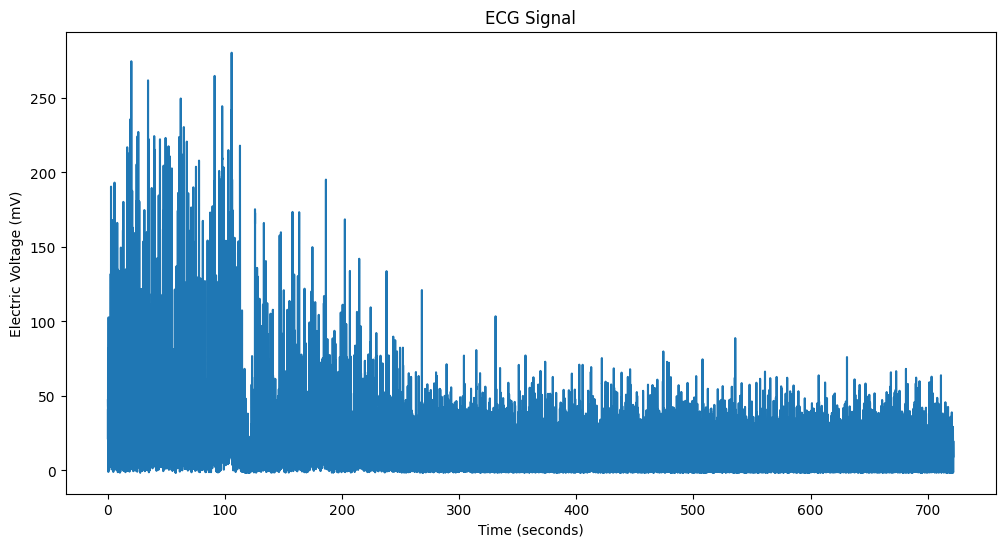

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_converted)
plt.xlabel('Time (seconds)')
# plt.xlim(300,310)
plt.ylabel('Electric Voltage (mV)')
plt.title('ECG Signal')
plt.show()

In [50]:
probable_peaks, possible_peaks = bsnb.detect._detects_peaks(ecg_converted, fs)
r_peaks = bsnb.detect_r_peaks(ecg_converted, fs, time_units=True, volts=False,
                                   resolution=resolution, plot_result=False)

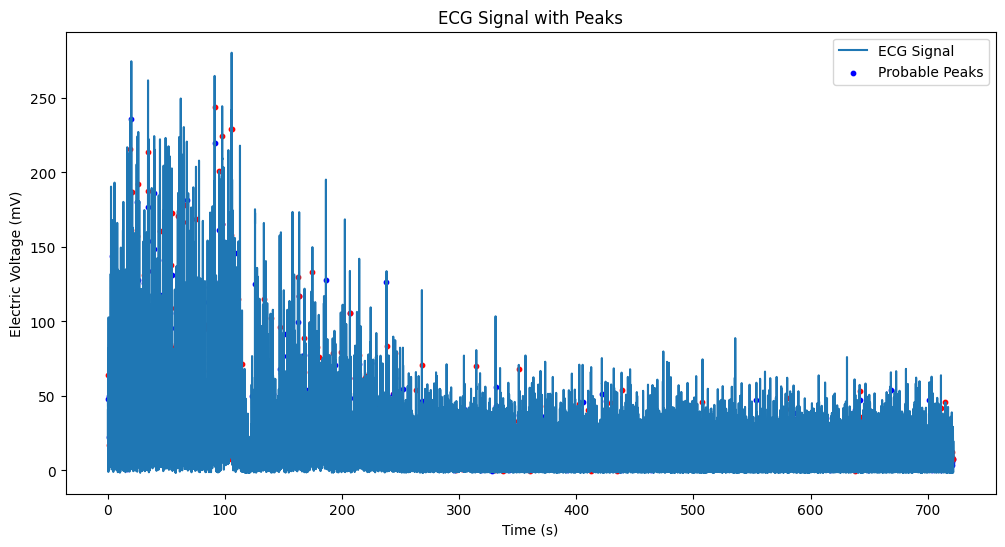

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(time, ecg_converted, label='ECG Signal')
plt.scatter(time[probable_peaks], ecg_converted[probable_peaks], s=10, color='blue', label='Probable Peaks')
plt.scatter(r_peaks[0], r_peaks[1], s=10, color='red')
plt.xlabel('Time (s)')
# plt.xlim(600,650)
plt.ylabel('Electric Voltage (mV)')
plt.title('ECG Signal with Peaks')
plt.legend()
plt.show()

In [52]:
tachogram, tachogram_time = bsnb.tachogram(ecg_converted, fs, signal=True, out_seconds = True)

def outlier_inds(data):
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    high_outlier = np.argwhere(data > q3 + 2.5*iqr)
    low_outlier = np.argwhere(data < q1 - 2.5*iqr)
    return np.append(high_outlier,low_outlier)

N = 500
i = 0
tach_outlier = np.copy(tachogram)
while i+N < tach_outlier.size:
  indices = outlier_inds(tach_outlier[i:i+N])
  tach_outlier = np.delete(tach_outlier, indices + i)
  i += 1

N = 20
moving_average = np.convolve(tachogram, np.ones(N)/N, mode='valid')

moving_variance = np.zeros_like(moving_average)
for i in range(moving_average.size):
  start = N//2
  moving_variance[i] = np.sum(np.square(tachogram[i:i+N]-moving_average[i]))/N


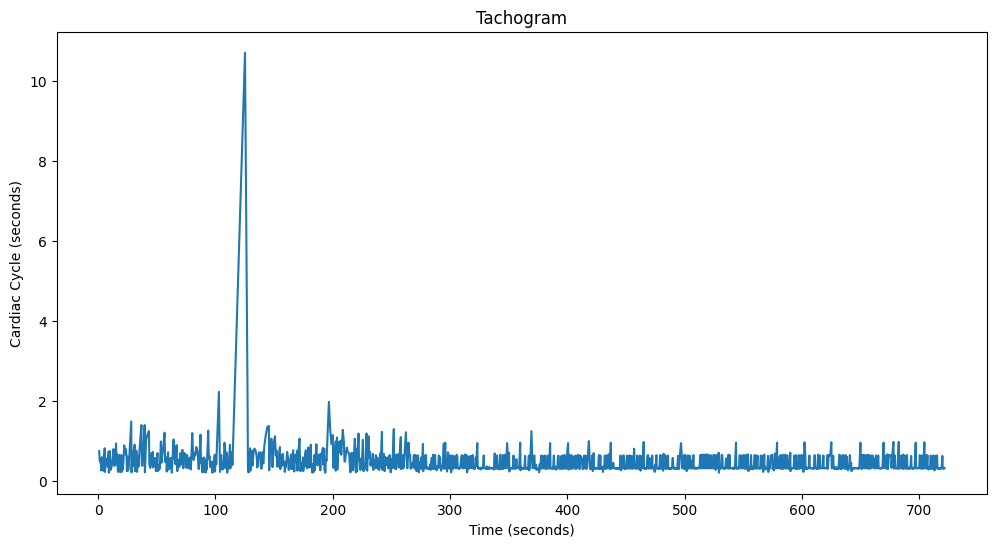

In [53]:
plt.figure(figsize=(12, 6))
# plt.plot(tachogram_time[:tach_outlier.size], tach_outlier, label='Tachogram')
plt.plot(tachogram_time, tachogram)
plt.xlabel('Time (seconds)')
# plt.xlim(140,160)
# plt.ylim(25,50)
plt.ylabel('Cardiac Cycle (seconds)')
plt.title('Tachogram')
plt.show()

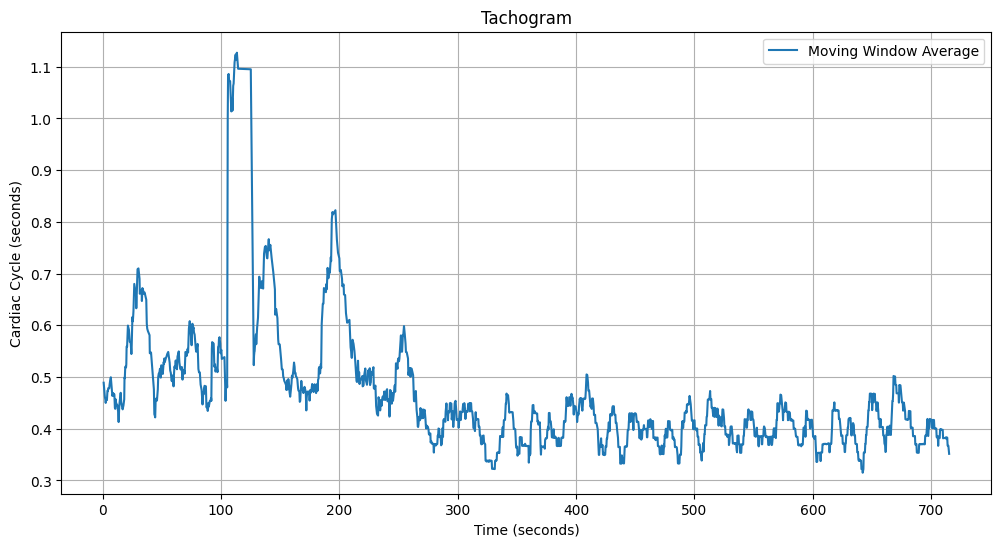

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(tachogram_time[:moving_average.size], moving_average, label='Moving Window Average')
plt.xlabel('Time (seconds)')
# plt.xlim(140,160)
# plt.ylim(25,50)
plt.ylabel('Cardiac Cycle (seconds)')
plt.title('Tachogram')
plt.legend()
plt.grid(True)
plt.show()

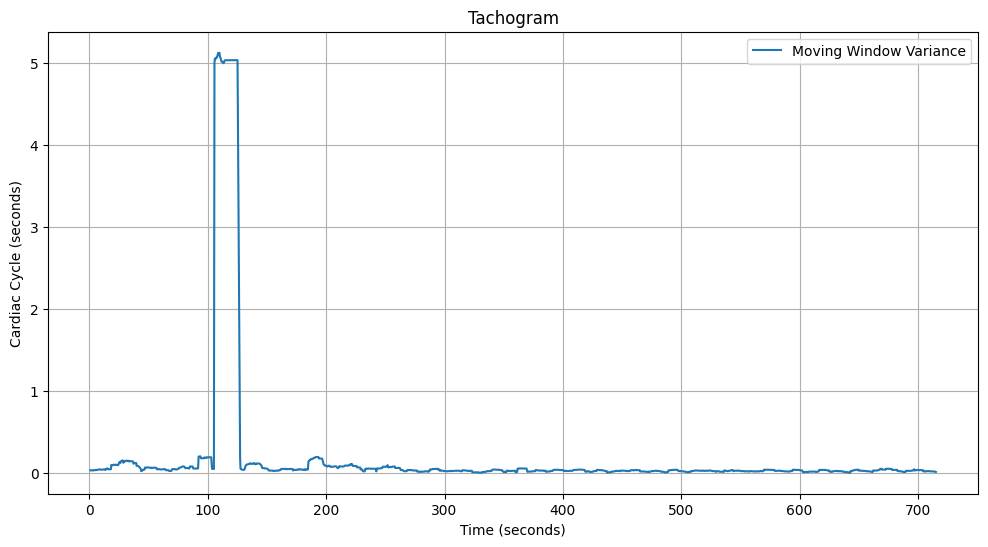

In [55]:
plt.figure(figsize=(12, 6))
# plt.plot(tachogram_time, tachogram, label='Tachogram')
plt.plot(tachogram_time[:np.size(moving_variance)], moving_variance, label='Moving Window Variance')
plt.xlabel('Time (seconds)')
# plt.xlim(140,160)
# plt.ylim(25,50)
plt.ylabel('Cardiac Cycle (seconds)')
plt.title('Tachogram')
plt.legend()
plt.grid(True)
plt.show()

# Statistics

In [56]:
emg_max_test = scipy.stats.ttest_ind(one_second_make_max, one_second_miss_max)
emg_diff_test = scipy.stats.ttest_ind(one_second_make_diff, one_second_miss_diff)
# hrv_diff_test not doing this one here bc the data is super noisy

print(emg_max_test)
print(emg_diff_test)

Ttest_indResult(statistic=-1.9763096761789312, pvalue=0.055223128992508315)
Ttest_indResult(statistic=-0.9705877531904354, pvalue=0.33773494098053014)
